# Part 3.3

Keeping the above two adjustments, replace your simple RNN model in Part 2 with a biL-STM model and a biGRU model, incorporating recurrent computations in both directions and stacking multiple layers if possible

Comparison between the models : 
+ (+)RNNs process data in a sequential manner (one direction); they retain information from previous steps but can struggle to remember distant information due to issues like vanishing gradients.
- (-)RNNs fail to capture long-term dependencies, especially in long sequences, as the information fades over time, and gradients vanish during backpropagation through time. Limits effectiveness in tasks requiring model to remember information over many time steps.
-----------------------------------------------
- (+)BiLSTM : Bidirectional Long Short-Term Memory, a RNN, handle long term dependencies better. It has gates that help regulate flow of information, enabling them to retain or discard information as needed.

- BiLSTM consists of 2 LSTM layers running in opposite directions : 1 processes sequence from past to future, while other processes it from future to past : captures both past and future context for each time step 

- BiLSTM helps to capture context from both directions, beneficial in tasks where understanding context of each word is important

- (-) BiLSTMs are computationally more intensive than regular LSTMs and RNNs due to bidirectional component and complexity of gating mechanism
-----------------------------------------------
- (+)BiGRU, type of RNN, has 2 gates instead of 3 used by LSTMS - makes GRUs faster to computer while still handling long-term dependencies better than traditional RNNs. Includes 2 GRU layers, one running forward one running backward, learnign both past and present context. 

- BiGRUs achieve similar performance to BiLSTMs but with fewer parameters and faster computation, making them more efficient for large datasets 

- (-)Although GRUs generally simpler and faster, might be less expressive in certain cases due to absence of output gate

In [1]:
from datasets import load_dataset
from utils.rnn_model import *
from utils.rnn_utils import *
from utils.utils import *
from dotenv import load_dotenv
import os

load_dotenv()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\qkm20\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Data preparation

In [2]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [3]:
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_non_oov.npy")

In [4]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

In [5]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [6]:
BATCH_SIZE = 32

In [7]:
trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# biL-STM model

In [8]:
MODEL_TYPE = "lstm"
LR = 0.0001

## Mean-Max Pool

### 2 layers

In [9]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2               # set to 2 for stacking multiple layers
)

In [10]:
# training with mean max pooling over the BiLSTM outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6926, Accuracy: 0.5347
Model saved.
Epoch   2/100, Loss: 0.6828, Accuracy: 0.5713
Model saved.
Epoch   3/100, Loss: 0.6616, Accuracy: 0.5863
Model saved.
Epoch   4/100, Loss: 0.6453, Accuracy: 0.5966
Model saved.
Epoch   5/100, Loss: 0.6302, Accuracy: 0.6060
Model saved.
Epoch   6/100, Loss: 0.6163, Accuracy: 0.6069
Model saved.
Epoch   7/100, Loss: 0.6051, Accuracy: 0.5919
Epoch   8/100, Loss: 0.5936, Accuracy: 0.5854
Epoch   9/100, Loss: 0.5837, Accuracy: 0.6116
Model saved.
Epoch  10/100, Loss: 0.5711, Accuracy: 0.5957
Epoch  11/100, Loss: 0.5618, Accuracy: 0.6051
Epoch  12/100, Loss: 0.5434, Accuracy: 0.5976
Epoch  13/100, Loss: 0.5307, Accuracy: 0.6173
Model saved.
Epoch  14/100, Loss: 0.5130, Accuracy: 0.6098
Epoch  15/100, Loss: 0.4944, Accuracy: 0.6154
Epoch  16/100, Loss: 0.4748, Accuracy: 0.6135
Epoch  17/100, Loss: 0.4632, Accuracy: 0.6023
Epoch  18/100, Loss: 0.4458, Accuracy: 0.6276
Model saved.
Epoch  19/100, Loss: 0.4144, Accuracy: 0.6248
Epoch  20

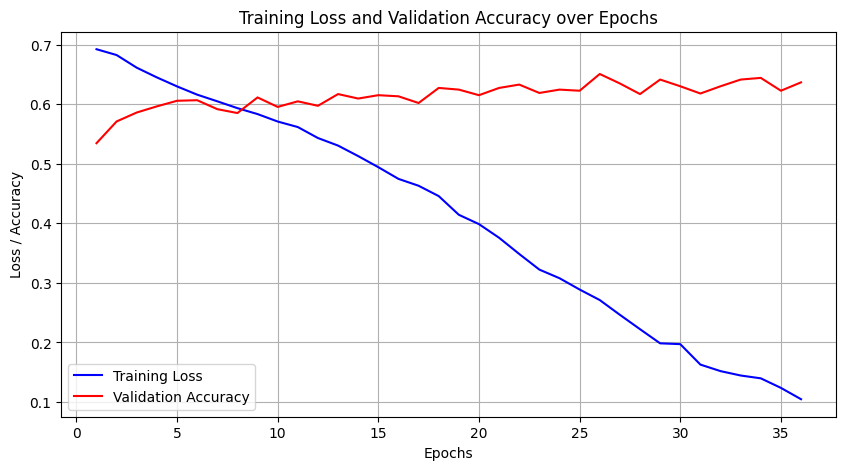

In [11]:
plot_loss_accuracy(losses, accuracies)

In [12]:
lstm_2_accuracy_mean_max = validate(model, tst_dataloader)

Accuracy: 0.6576


### 4 layers

Trying with an increased number of stack layers

In [13]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4               # increased to 4 for stacking multiple layers
)

In [14]:
# training with mean max pooling over the BiLSTM outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6932, Accuracy: 0.5000
Model saved.
Epoch   2/100, Loss: 0.6857, Accuracy: 0.5647
Model saved.
Epoch   3/100, Loss: 0.6624, Accuracy: 0.5816
Model saved.
Epoch   4/100, Loss: 0.6427, Accuracy: 0.6004
Model saved.
Epoch   5/100, Loss: 0.6287, Accuracy: 0.5957
Epoch   6/100, Loss: 0.6158, Accuracy: 0.6004
Epoch   7/100, Loss: 0.6070, Accuracy: 0.5947
Epoch   8/100, Loss: 0.5947, Accuracy: 0.6004
Epoch   9/100, Loss: 0.5800, Accuracy: 0.5966
Epoch  10/100, Loss: 0.5675, Accuracy: 0.5957
Epoch  11/100, Loss: 0.5530, Accuracy: 0.6173
Model saved.
Epoch  12/100, Loss: 0.5375, Accuracy: 0.6041
Epoch  13/100, Loss: 0.5197, Accuracy: 0.6248
Model saved.
Epoch  14/100, Loss: 0.5035, Accuracy: 0.6126
Epoch  15/100, Loss: 0.4850, Accuracy: 0.6051
Epoch  16/100, Loss: 0.4658, Accuracy: 0.6276
Model saved.
Epoch  17/100, Loss: 0.4417, Accuracy: 0.6248
Epoch  18/100, Loss: 0.4227, Accuracy: 0.6257
Epoch  19/100, Loss: 0.4001, Accuracy: 0.6276
Epoch  20/100, Loss: 0.3813, Accura

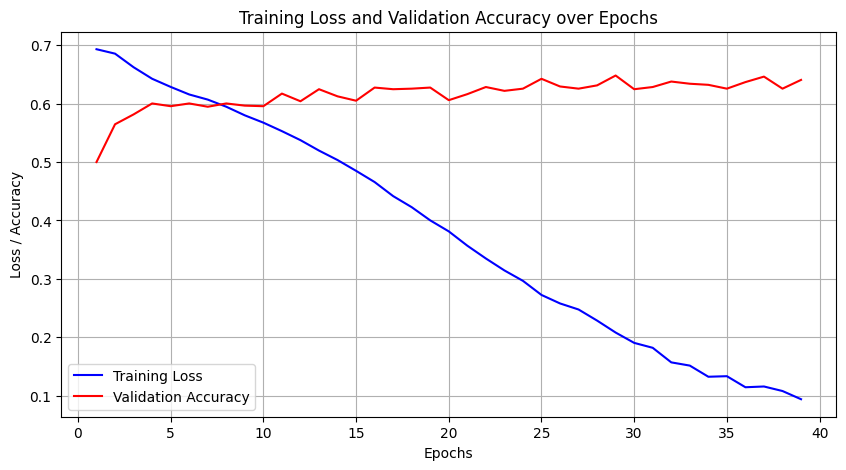

In [15]:
plot_loss_accuracy(losses, accuracies)

In [16]:
lstm_4_accuracy_mean_max = validate(model, tst_dataloader)

Accuracy: 0.6492


## Max Pool

### 2 layers


In [17]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2               # set to 2 for stacking multiple layers
)

In [18]:
# training with max pooling over the BiLSTM outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"
)

Epoch   1/100, Loss: 0.6929, Accuracy: 0.4981
Model saved.
Epoch   2/100, Loss: 0.6842, Accuracy: 0.5694
Model saved.
Epoch   3/100, Loss: 0.6630, Accuracy: 0.5966
Model saved.
Epoch   4/100, Loss: 0.6459, Accuracy: 0.5854
Epoch   5/100, Loss: 0.6329, Accuracy: 0.5910
Epoch   6/100, Loss: 0.6194, Accuracy: 0.5994
Model saved.
Epoch   7/100, Loss: 0.6071, Accuracy: 0.6023
Model saved.
Epoch   8/100, Loss: 0.5963, Accuracy: 0.5938
Epoch   9/100, Loss: 0.5859, Accuracy: 0.6041
Model saved.
Epoch  10/100, Loss: 0.5724, Accuracy: 0.6013
Epoch  11/100, Loss: 0.5559, Accuracy: 0.6088
Model saved.
Epoch  12/100, Loss: 0.5470, Accuracy: 0.6023
Epoch  13/100, Loss: 0.5305, Accuracy: 0.6013
Epoch  14/100, Loss: 0.5130, Accuracy: 0.6088
Epoch  15/100, Loss: 0.4944, Accuracy: 0.6041
Epoch  16/100, Loss: 0.4793, Accuracy: 0.6285
Model saved.
Epoch  17/100, Loss: 0.4538, Accuracy: 0.5910
Epoch  18/100, Loss: 0.4354, Accuracy: 0.6379
Model saved.
Epoch  19/100, Loss: 0.4136, Accuracy: 0.6313
Epoch  20

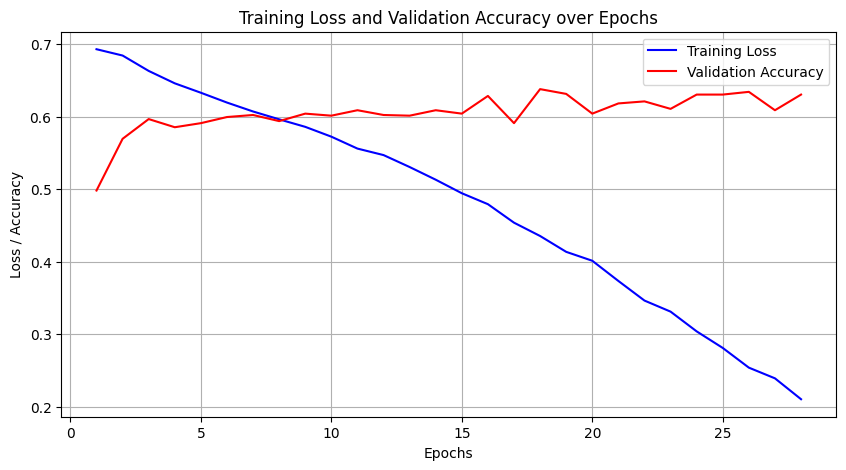

In [19]:
plot_loss_accuracy(losses, accuracies)

In [20]:
lstm_2_accuracy_max_pool = validate(model, tst_dataloader)

Accuracy: 0.6295


### 4 layers


In [21]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4               # increased to 4 for stacking multiple layers
)

In [22]:
# training with max pooling over the BiLSTM outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"
)

Epoch   1/100, Loss: 0.6936, Accuracy: 0.5188
Model saved.
Epoch   2/100, Loss: 0.6822, Accuracy: 0.5788
Model saved.
Epoch   3/100, Loss: 0.6579, Accuracy: 0.5929
Model saved.
Epoch   4/100, Loss: 0.6381, Accuracy: 0.5966
Model saved.
Epoch   5/100, Loss: 0.6247, Accuracy: 0.5910
Epoch   6/100, Loss: 0.6113, Accuracy: 0.6051
Model saved.
Epoch   7/100, Loss: 0.6028, Accuracy: 0.5957
Epoch   8/100, Loss: 0.5880, Accuracy: 0.5976
Epoch   9/100, Loss: 0.5757, Accuracy: 0.6041
Epoch  10/100, Loss: 0.5611, Accuracy: 0.6107
Model saved.
Epoch  11/100, Loss: 0.5469, Accuracy: 0.6051
Epoch  12/100, Loss: 0.5285, Accuracy: 0.6098
Epoch  13/100, Loss: 0.5150, Accuracy: 0.6154
Model saved.
Epoch  14/100, Loss: 0.4948, Accuracy: 0.6182
Model saved.
Epoch  15/100, Loss: 0.4745, Accuracy: 0.6238
Model saved.
Epoch  16/100, Loss: 0.4525, Accuracy: 0.6163
Epoch  17/100, Loss: 0.4330, Accuracy: 0.5966
Epoch  18/100, Loss: 0.4152, Accuracy: 0.6285
Model saved.
Epoch  19/100, Loss: 0.3917, Accuracy: 0.6

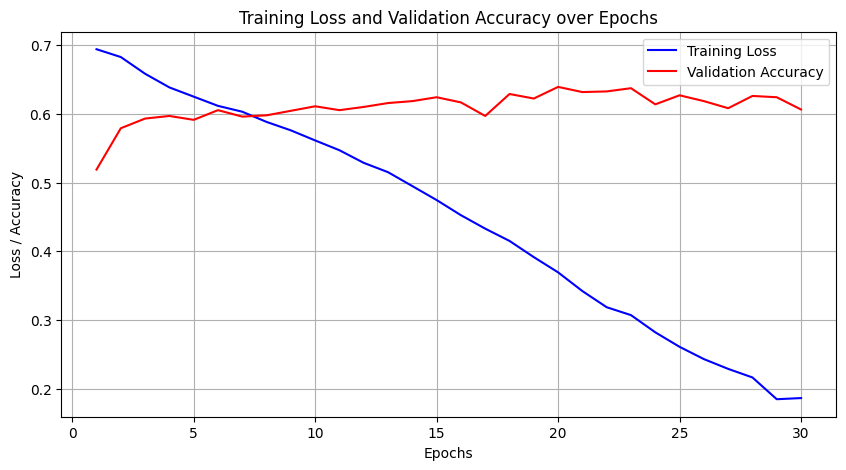

In [23]:
plot_loss_accuracy(losses, accuracies)

In [24]:
lstm_4_accuracy_max_pool = validate(model, tst_dataloader)

Accuracy: 0.6379


## Attention model


### 2 layers

In [25]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2               # set to 2 for stacking multiple layers
)

In [26]:
# training with attention pooling over the BiLSTM outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6930, Accuracy: 0.5347
Model saved.
Epoch   2/100, Loss: 0.6879, Accuracy: 0.5450
Model saved.
Epoch   3/100, Loss: 0.6684, Accuracy: 0.5779
Model saved.
Epoch   4/100, Loss: 0.6473, Accuracy: 0.5882
Model saved.
Epoch   5/100, Loss: 0.6289, Accuracy: 0.5985
Model saved.
Epoch   6/100, Loss: 0.6166, Accuracy: 0.5891
Epoch   7/100, Loss: 0.6063, Accuracy: 0.6163
Model saved.
Epoch   8/100, Loss: 0.5911, Accuracy: 0.6098
Epoch   9/100, Loss: 0.5798, Accuracy: 0.6069
Epoch  10/100, Loss: 0.5682, Accuracy: 0.6060
Epoch  11/100, Loss: 0.5561, Accuracy: 0.6079
Epoch  12/100, Loss: 0.5396, Accuracy: 0.6163
Epoch  13/100, Loss: 0.5259, Accuracy: 0.6154
Epoch  14/100, Loss: 0.5091, Accuracy: 0.6116
Epoch  15/100, Loss: 0.4928, Accuracy: 0.6098
Epoch  16/100, Loss: 0.4785, Accuracy: 0.6257
Model saved.
Epoch  17/100, Loss: 0.4551, Accuracy: 0.6276
Model saved.
Epoch  18/100, Loss: 0.4389, Accuracy: 0.6379
Model saved.
Epoch  19/100, Loss: 0.4135, Accuracy: 0.6088
Epoch  20

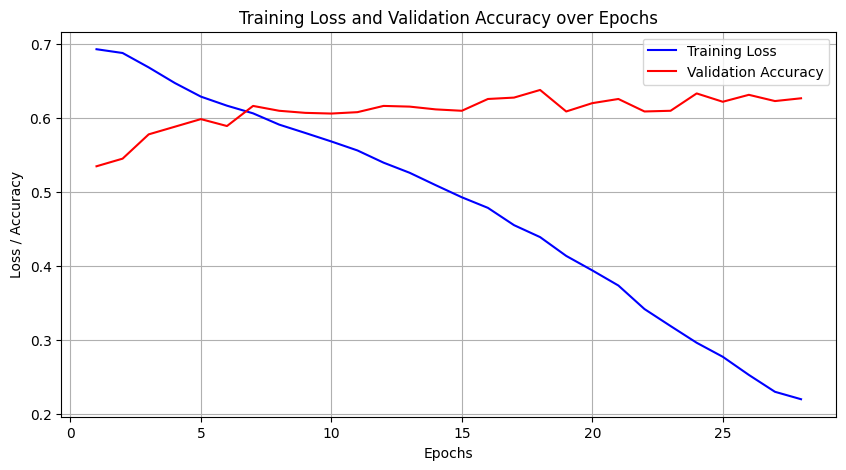

In [27]:
plot_loss_accuracy(losses, accuracies)

In [28]:
lstm_2_accuracy_attention = validate(model, tst_dataloader)

Accuracy: 0.6445


### 4 layers

In [29]:
# initialize BiLSTM model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=4               # set to 4 for stacking multiple layers
)

In [30]:
# training with attention pooling over the BiLSTM outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6933, Accuracy: 0.5488
Model saved.
Epoch   2/100, Loss: 0.6835, Accuracy: 0.5788
Model saved.
Epoch   3/100, Loss: 0.6582, Accuracy: 0.5985
Model saved.
Epoch   4/100, Loss: 0.6396, Accuracy: 0.5985
Epoch   5/100, Loss: 0.6245, Accuracy: 0.5938
Epoch   6/100, Loss: 0.6146, Accuracy: 0.5976
Epoch   7/100, Loss: 0.6043, Accuracy: 0.6032
Model saved.
Epoch   8/100, Loss: 0.5902, Accuracy: 0.5976
Epoch   9/100, Loss: 0.5787, Accuracy: 0.5976
Epoch  10/100, Loss: 0.5670, Accuracy: 0.5994
Epoch  11/100, Loss: 0.5463, Accuracy: 0.6144
Model saved.
Epoch  12/100, Loss: 0.5363, Accuracy: 0.6238
Model saved.
Epoch  13/100, Loss: 0.5170, Accuracy: 0.6079
Epoch  14/100, Loss: 0.5015, Accuracy: 0.6060
Epoch  15/100, Loss: 0.4779, Accuracy: 0.6135
Epoch  16/100, Loss: 0.4621, Accuracy: 0.6173
Epoch  17/100, Loss: 0.4334, Accuracy: 0.6126
Epoch  18/100, Loss: 0.4121, Accuracy: 0.6032
Epoch  19/100, Loss: 0.3882, Accuracy: 0.6220
Epoch  20/100, Loss: 0.3655, Accuracy: 0.6229
Ep

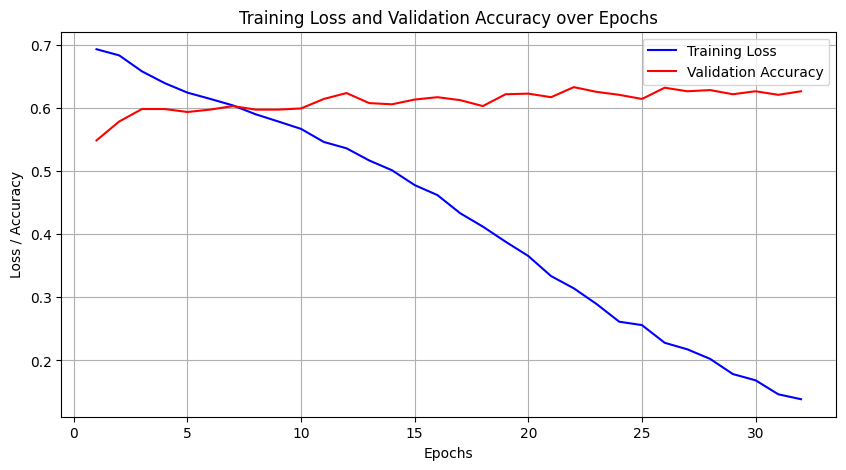

In [31]:
plot_loss_accuracy(losses, accuracies)

In [32]:
lstm_4_accuracy_attention = validate(model, tst_dataloader)

Accuracy: 0.6276


# biGRU model

In [33]:
MODEL_TYPE = "gru"
LR = 0.0001

## Mean-Max Pool

### 2 layers

In [34]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=2               # set to 2 for stacking multiple layers
)

In [35]:
# training with mean max pooling over the biGRU outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6919, Accuracy: 0.5375
Model saved.
Epoch   2/100, Loss: 0.6774, Accuracy: 0.5901
Model saved.
Epoch   3/100, Loss: 0.6583, Accuracy: 0.5994
Model saved.
Epoch   4/100, Loss: 0.6420, Accuracy: 0.5929
Epoch   5/100, Loss: 0.6292, Accuracy: 0.5760
Epoch   6/100, Loss: 0.6157, Accuracy: 0.5779
Epoch   7/100, Loss: 0.6079, Accuracy: 0.5872
Epoch   8/100, Loss: 0.5949, Accuracy: 0.5929
Epoch   9/100, Loss: 0.5843, Accuracy: 0.5732
Epoch  10/100, Loss: 0.5753, Accuracy: 0.5891
Epoch  11/100, Loss: 0.5620, Accuracy: 0.5994
Epoch  12/100, Loss: 0.5510, Accuracy: 0.5863
Epoch  13/100, Loss: 0.5361, Accuracy: 0.5788
Early stopping triggered after 13 epochs.
Training ended, loading best model...
Model loaded.


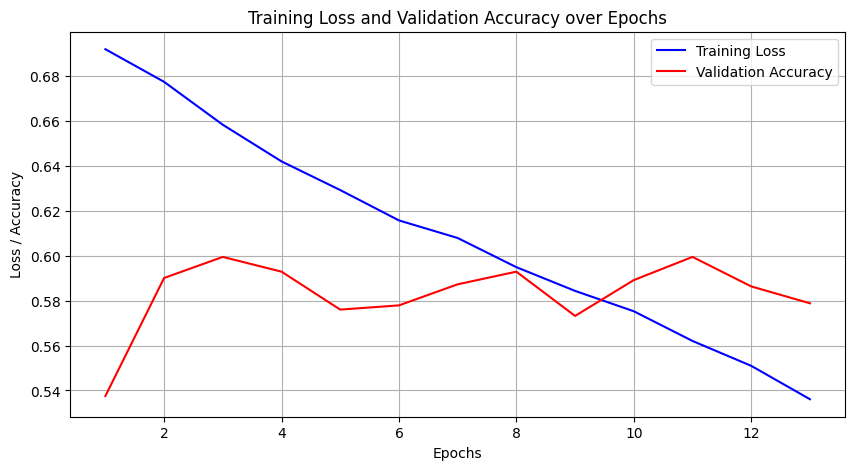

In [36]:
plot_loss_accuracy(losses, accuracies)

In [37]:
gru_2_accuracy_mean_max = validate(model, tst_dataloader)

Accuracy: 0.6173


### 4 layers

Trying with an increased number of stack layers

In [38]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4               # increased to 4 for stacking multiple layers
)

In [39]:
# training with mean max pooling over the biGRU outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="mean_max"
)

Epoch   1/100, Loss: 0.6916, Accuracy: 0.5629
Model saved.
Epoch   2/100, Loss: 0.6725, Accuracy: 0.5807
Model saved.
Epoch   3/100, Loss: 0.6507, Accuracy: 0.5872
Model saved.
Epoch   4/100, Loss: 0.6323, Accuracy: 0.5863
Epoch   5/100, Loss: 0.6233, Accuracy: 0.5966
Model saved.
Epoch   6/100, Loss: 0.6089, Accuracy: 0.5910
Epoch   7/100, Loss: 0.5982, Accuracy: 0.5844
Epoch   8/100, Loss: 0.5887, Accuracy: 0.5844
Epoch   9/100, Loss: 0.5764, Accuracy: 0.5713
Epoch  10/100, Loss: 0.5657, Accuracy: 0.5844
Epoch  11/100, Loss: 0.5550, Accuracy: 0.5844
Epoch  12/100, Loss: 0.5414, Accuracy: 0.5872
Epoch  13/100, Loss: 0.5223, Accuracy: 0.6088
Model saved.
Epoch  14/100, Loss: 0.5083, Accuracy: 0.6116
Model saved.
Epoch  15/100, Loss: 0.4902, Accuracy: 0.6116
Epoch  16/100, Loss: 0.4677, Accuracy: 0.5994
Epoch  17/100, Loss: 0.4443, Accuracy: 0.6004
Epoch  18/100, Loss: 0.4256, Accuracy: 0.6060
Epoch  19/100, Loss: 0.4134, Accuracy: 0.6004
Epoch  20/100, Loss: 0.3797, Accuracy: 0.6276
Mo

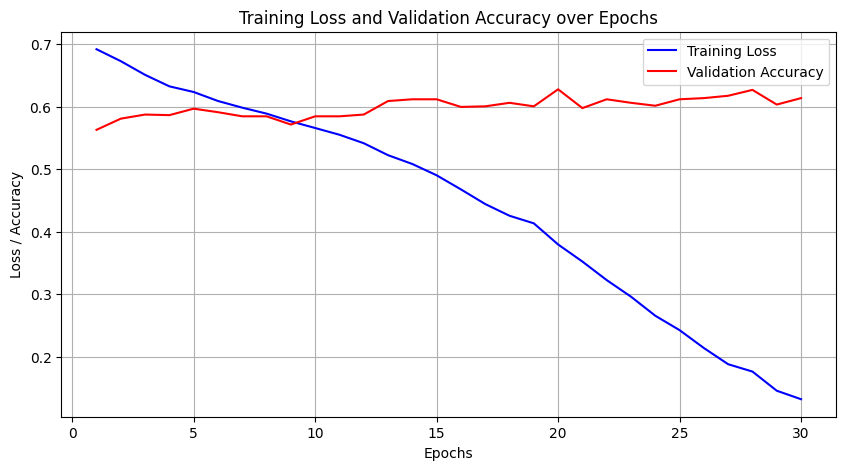

In [40]:
plot_loss_accuracy(losses, accuracies)

In [41]:
gru_4_accuracy_mean_max = validate(model, tst_dataloader)

Accuracy: 0.6098


## Max Pool

### 2 layers

In [42]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "lstm" for BiLSTM
    bidirectional=True,        # enable bidirectionality
    num_layers=2               # set to 2 for stacking multiple layers
)

In [43]:
# training with  max pooling over the biGRU outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"
)

Epoch   1/100, Loss: 0.6919, Accuracy: 0.5000
Model saved.
Epoch   2/100, Loss: 0.6824, Accuracy: 0.5844
Model saved.
Epoch   3/100, Loss: 0.6615, Accuracy: 0.5882
Model saved.
Epoch   4/100, Loss: 0.6446, Accuracy: 0.5732
Epoch   5/100, Loss: 0.6303, Accuracy: 0.5863
Epoch   6/100, Loss: 0.6214, Accuracy: 0.5807
Epoch   7/100, Loss: 0.6074, Accuracy: 0.5910
Model saved.
Epoch   8/100, Loss: 0.5994, Accuracy: 0.5891
Epoch   9/100, Loss: 0.5881, Accuracy: 0.5901
Epoch  10/100, Loss: 0.5767, Accuracy: 0.5732
Epoch  11/100, Loss: 0.5642, Accuracy: 0.5826
Epoch  12/100, Loss: 0.5521, Accuracy: 0.5938
Model saved.
Epoch  13/100, Loss: 0.5420, Accuracy: 0.5919
Epoch  14/100, Loss: 0.5266, Accuracy: 0.5835
Epoch  15/100, Loss: 0.5115, Accuracy: 0.5816
Epoch  16/100, Loss: 0.4994, Accuracy: 0.5760
Epoch  17/100, Loss: 0.4787, Accuracy: 0.5985
Model saved.
Epoch  18/100, Loss: 0.4682, Accuracy: 0.6023
Model saved.
Epoch  19/100, Loss: 0.4417, Accuracy: 0.5985
Epoch  20/100, Loss: 0.4227, Accura

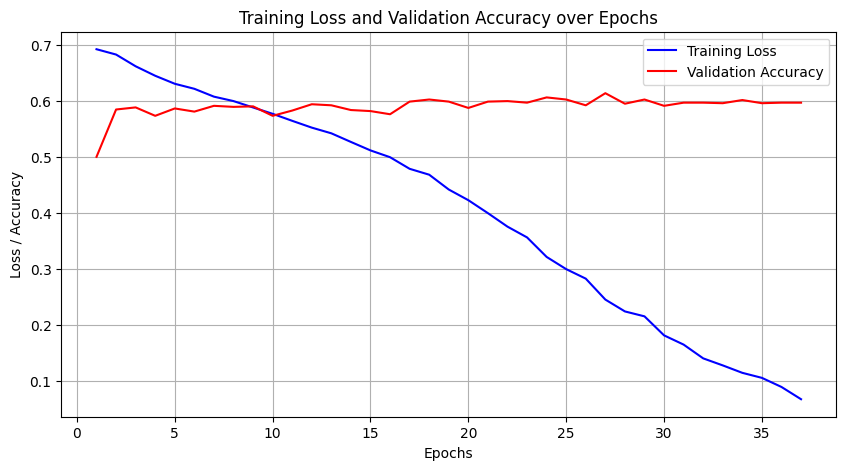

In [44]:
plot_loss_accuracy(losses, accuracies)

In [45]:
gru_2_accuracy_max_pool = validate(model, tst_dataloader)

Accuracy: 0.6313


### 4 layers

In [46]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4               # increased to 4 for stacking multiple layers
)

In [47]:
# training with max pooling over the biGRU outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="max_pool"
)

Epoch   1/100, Loss: 0.6934, Accuracy: 0.5263
Model saved.
Epoch   2/100, Loss: 0.6766, Accuracy: 0.5769
Model saved.
Epoch   3/100, Loss: 0.6547, Accuracy: 0.5675
Epoch   4/100, Loss: 0.6352, Accuracy: 0.5769
Epoch   5/100, Loss: 0.6215, Accuracy: 0.5722
Epoch   6/100, Loss: 0.6119, Accuracy: 0.5844
Model saved.
Epoch   7/100, Loss: 0.5996, Accuracy: 0.5882
Model saved.
Epoch   8/100, Loss: 0.5922, Accuracy: 0.5854
Epoch   9/100, Loss: 0.5767, Accuracy: 0.5901
Model saved.
Epoch  10/100, Loss: 0.5641, Accuracy: 0.5891
Epoch  11/100, Loss: 0.5512, Accuracy: 0.5816
Epoch  12/100, Loss: 0.5384, Accuracy: 0.5826
Epoch  13/100, Loss: 0.5234, Accuracy: 0.6023
Model saved.
Epoch  14/100, Loss: 0.5046, Accuracy: 0.6088
Model saved.
Epoch  15/100, Loss: 0.4904, Accuracy: 0.5929
Epoch  16/100, Loss: 0.4649, Accuracy: 0.6023
Epoch  17/100, Loss: 0.4422, Accuracy: 0.6154
Model saved.
Epoch  18/100, Loss: 0.4240, Accuracy: 0.6060
Epoch  19/100, Loss: 0.3989, Accuracy: 0.6079
Epoch  20/100, Loss: 0

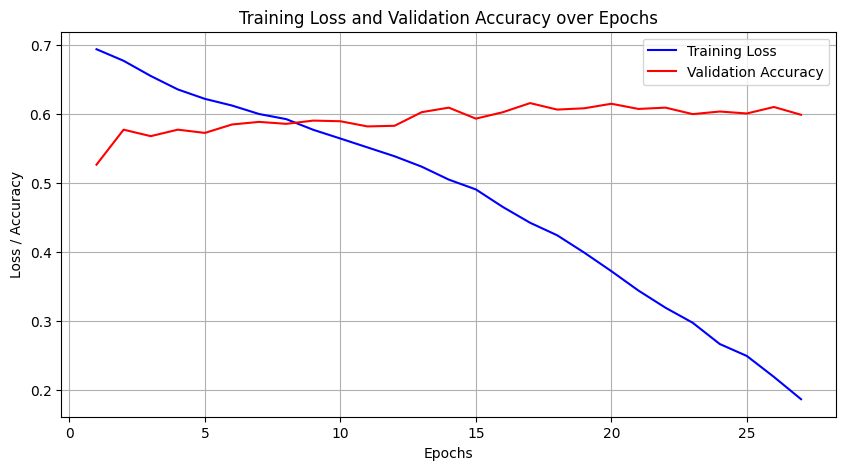

In [48]:
plot_loss_accuracy(losses, accuracies)

In [49]:
gru_4_accuracy_max_pool = validate(model, tst_dataloader)

Accuracy: 0.6370


## Attention Model

### 2 layers

In [50]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=2               # set to 2 for stacking multiple layers
)

In [51]:
# training with attention pooling over the biGRU outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_2-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6921, Accuracy: 0.5235
Model saved.
Epoch   2/100, Loss: 0.6790, Accuracy: 0.5675
Model saved.
Epoch   3/100, Loss: 0.6603, Accuracy: 0.5872
Model saved.
Epoch   4/100, Loss: 0.6413, Accuracy: 0.5760
Epoch   5/100, Loss: 0.6311, Accuracy: 0.5769
Epoch   6/100, Loss: 0.6171, Accuracy: 0.5704
Epoch   7/100, Loss: 0.6048, Accuracy: 0.5816
Epoch   8/100, Loss: 0.5981, Accuracy: 0.5835
Epoch   9/100, Loss: 0.5858, Accuracy: 0.5779
Epoch  10/100, Loss: 0.5769, Accuracy: 0.5826
Epoch  11/100, Loss: 0.5631, Accuracy: 0.5844
Epoch  12/100, Loss: 0.5529, Accuracy: 0.5957
Model saved.
Epoch  13/100, Loss: 0.5397, Accuracy: 0.5901
Epoch  14/100, Loss: 0.5265, Accuracy: 0.5666
Epoch  15/100, Loss: 0.5129, Accuracy: 0.5947
Epoch  16/100, Loss: 0.4976, Accuracy: 0.5769
Epoch  17/100, Loss: 0.4789, Accuracy: 0.5835
Epoch  18/100, Loss: 0.4607, Accuracy: 0.6116
Model saved.
Epoch  19/100, Loss: 0.4359, Accuracy: 0.5957
Epoch  20/100, Loss: 0.4180, Accuracy: 0.6079
Epoch  21/100, 

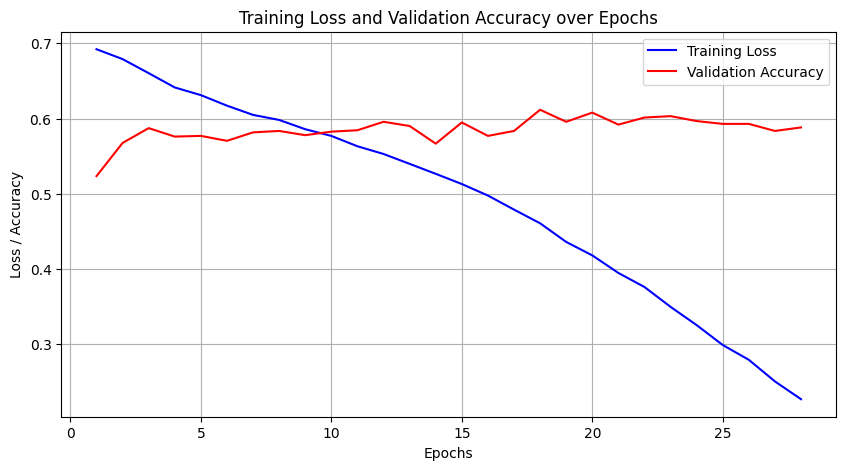

In [52]:
plot_loss_accuracy(losses, accuracies)

In [53]:
gru_2_accuracy_attention = validate(model, tst_dataloader)

Accuracy: 0.6445


### 4 layers


In [54]:
# initialize biGRU model with both directions and multiple layers
model = RNNModel(
    embedding_dim=350,
    hidden_size=256,
    embedding_matrix=word2vec_model.vectors,
    rnn_type=MODEL_TYPE,       # alr set to "gru" for biGRU
    bidirectional=True,        # enable bidirectionality
    num_layers=4               # set to 4 for stacking multiple layers
)

In [55]:
# training with attention pooling over the BiLSTM outputs
losses, accuracies = train(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    version="3_4-layer",
    model_type=MODEL_TYPE,
    model_save_path=os.getenv("MODEL_SAVE_PATH", "modelfiles/"),
    optimizer=torch.optim.Adam(model.parameters(), lr=LR),
    epochs=100,
    early_stopping_patience=10,
    train_mode="attention"
)

Epoch   1/100, Loss: 0.6910, Accuracy: 0.5432
Model saved.
Epoch   2/100, Loss: 0.6717, Accuracy: 0.5666
Model saved.
Epoch   3/100, Loss: 0.6533, Accuracy: 0.5704
Model saved.
Epoch   4/100, Loss: 0.6364, Accuracy: 0.5947
Model saved.
Epoch   5/100, Loss: 0.6247, Accuracy: 0.5891
Epoch   6/100, Loss: 0.6110, Accuracy: 0.5807
Epoch   7/100, Loss: 0.6001, Accuracy: 0.5901
Epoch   8/100, Loss: 0.5865, Accuracy: 0.5882
Epoch   9/100, Loss: 0.5756, Accuracy: 0.5835
Epoch  10/100, Loss: 0.5651, Accuracy: 0.5844
Epoch  11/100, Loss: 0.5540, Accuracy: 0.5891
Epoch  12/100, Loss: 0.5360, Accuracy: 0.5741
Epoch  13/100, Loss: 0.5215, Accuracy: 0.5910
Epoch  14/100, Loss: 0.5035, Accuracy: 0.5985
Model saved.
Epoch  15/100, Loss: 0.4807, Accuracy: 0.5797
Epoch  16/100, Loss: 0.4593, Accuracy: 0.5797
Epoch  17/100, Loss: 0.4422, Accuracy: 0.5985
Epoch  18/100, Loss: 0.4182, Accuracy: 0.5966
Epoch  19/100, Loss: 0.4001, Accuracy: 0.6023
Model saved.
Epoch  20/100, Loss: 0.3669, Accuracy: 0.5947
Ep

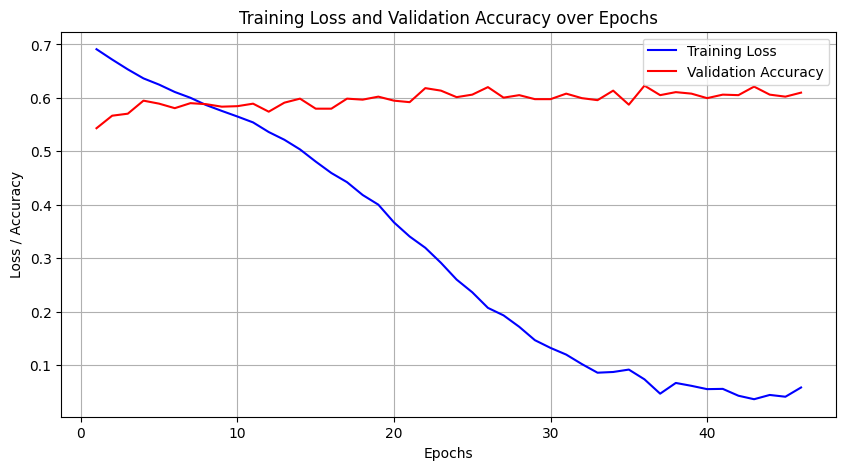

In [56]:
plot_loss_accuracy(losses, accuracies)

In [57]:
gru_4_accuracy_attention = validate(model, tst_dataloader)

Accuracy: 0.6351


# Results

In [59]:
print(f"Mean_Max_Pool")
print(f"2 layer biL-STM Test Accuracy:  {lstm_2_accuracy_mean_max:.4f}")
print(f"4 layer biL-STM Test Accuracy:  {lstm_4_accuracy_mean_max:.4f}")
print(f"Max_Pool")
print(f"2 layer bi-STM Test Accuracy:   {lstm_2_accuracy_max_pool:.4f}")
print(f"4 layer bi-STM Test Accuracy:   {lstm_4_accuracy_max_pool:.4f}")
print(f"Attention_Pool")
print(f"2 layer bi-STM Test Accuracy:   {lstm_2_accuracy_attention:.4f}")
print(f"4 layer bi-STM Test Accuracy:   {lstm_4_accuracy_attention:.4f}")
print(f"Mean_Max_Pool")
print(f"2 layer bi-GRU Test Accuracy:   {gru_2_accuracy_mean_max:.4f}")
print(f"4 layer bi-GRU Test Accuracy:   {gru_4_accuracy_mean_max:.4f}")
print(f"Max_Pool")
print(f"2 layer bi-GRU Test Accuracy:   {gru_2_accuracy_max_pool:.4f}")
print(f"4 layer bi-GRU Test Accuracy:   {gru_4_accuracy_max_pool:.4f}")
print(f"Attention_Pool")
print(f"2 layer bi-GRU Test Accuracy:   {gru_2_accuracy_attention:.4f}")
print(f"4 layer bi-GRU Test Accuracy:   {gru_4_accuracy_attention:.4f}")

Mean_Max_Pool
2 layer biL-STM Test Accuracy:  0.6576
4 layer biL-STM Test Accuracy:  0.6492
Max_Pool
2 layer bi-STM Test Accuracy:   0.6295
4 layer bi-STM Test Accuracy:   0.6379
Attention_Pool
2 layer bi-STM Test Accuracy:   0.6445
4 layer bi-STM Test Accuracy:   0.6276
Mean_Max_Pool
2 layer bi-GRU Test Accuracy:   0.6173
4 layer bi-GRU Test Accuracy:   0.6098
Max_Pool
2 layer bi-GRU Test Accuracy:   0.6313
4 layer bi-GRU Test Accuracy:   0.6370
Attention_Pool
2 layer bi-GRU Test Accuracy:   0.6445
4 layer bi-GRU Test Accuracy:   0.6351
